In [17]:
import torch
import torch.nn.functional as F

In [18]:
scores = torch.rand(10)
tk = scores.topk(5).indices

In [19]:
w = torch.tensor([1/(k+1) for k in range(5)], dtype=torch.float32, requires_grad=True)

s = F.softmax(w, dim=0)
ls = F.log_softmax(w, dim=0)
w,s,ls

(tensor([1.0000, 0.5000, 0.3333, 0.2500, 0.2000], requires_grad=True),
 tensor([0.3288, 0.1994, 0.1688, 0.1553, 0.1477], grad_fn=<SoftmaxBackward0>),
 tensor([-1.1124, -1.6124, -1.7791, -1.8624, -1.9124],
        grad_fn=<LogSoftmaxBackward0>))

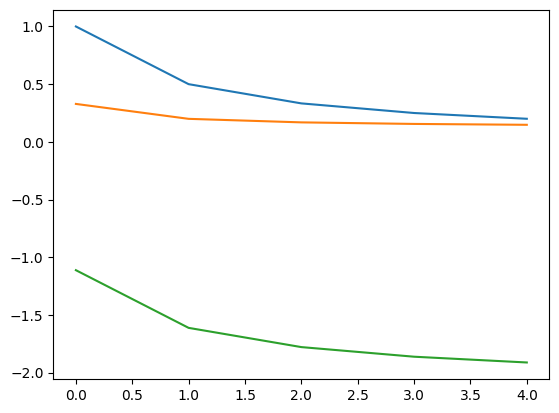

In [20]:
import matplotlib.pyplot as plt

plt.plot(w.detach().numpy(), label='w')
plt.plot(s.detach().numpy(), label='s')
plt.plot(ls.detach().numpy(), label='ls')

In [23]:
w, scores, scores[tk], scores[tk] * w, scores[tk] * s, scores[tk] * ls

(tensor([1.0000, 0.5000, 0.3333, 0.2500, 0.2000], requires_grad=True),
 tensor([0.9205, 0.1195, 0.4207, 0.6318, 0.1963, 0.6741, 0.1797, 0.6193, 0.7459,
         0.0239]),
 tensor([0.9205, 0.7459, 0.6741, 0.6318, 0.6193]),
 tensor([0.9205, 0.3729, 0.2247, 0.1580, 0.1239], grad_fn=<MulBackward0>),
 tensor([0.3026, 0.1487, 0.1138, 0.0981, 0.0915], grad_fn=<MulBackward0>),
 tensor([-1.0239, -1.2026, -1.1992, -1.1767, -1.1844], grad_fn=<MulBackward0>))

In [25]:
lscores = torch.zeros_like(scores)
lscores[tk] = scores[tk] * ls

In [26]:
lscores

tensor([-1.0239,  0.0000,  0.0000, -1.1767,  0.0000, -1.1992,  0.0000, -1.1844,
        -1.2026,  0.0000], grad_fn=<IndexPutBackward0>)

In [ ]:
scores[tk] = scores[tk] * w

In [28]:
scores = torch.rand(10)
tk = scores.topk(5).indices

w = torch.tensor([1/(k+1) for k in range(5)], dtype=torch.float32, requires_grad=True)
ls = F.log_softmax(w, dim=0)

lscores = torch.zeros_like(scores)
lscores[tk] = scores[tk] * ls
scores, lscores

(tensor([0.2354, 0.6039, 0.3375, 0.7665, 0.7575, 0.3047, 0.1899, 0.9926, 0.5916,
         0.6377]),
 tensor([ 0.0000, -1.1550,  0.0000, -1.2360, -1.3476,  0.0000,  0.0000, -1.1042,
          0.0000, -1.1876], grad_fn=<IndexPutBackward0>))

In [30]:
label = torch.tensor([3])
criterion = torch.nn.NLLLoss()

loss = criterion(lscores.unsqueeze(0), label)
loss

tensor(1.2360, grad_fn=<NllLossBackward0>)

In [31]:
torch.nn.CrossEntropyLoss()(scores.unsqueeze(0), label)

tensor(2.1095)